In [34]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
df_daily = pd.read_csv('data/daily.csv', parse_dates=['date'])
df_daily.describe()

,date,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_origValue,WTEQ_value,site_no,CFS
count,12585,12344.000000,12343.000000,12584.000000,12584.000000,12584.000000,12584.0,12584.000000
mean,2007-03-25 00:00:00,33.649141,33.656769,9.789860,9.666910,9.685386,6043500.0,820.263907
min,1990-01-01 00:00:00,-37.300000,-37.300000,0.000000,-4.700000,0.000000,6043500.0,153.000000
25%,1998-08-13 00:00:00,23.400000,23.400000,0.600000,0.100000,0.000000,6043500.0,313.000000
50%,2007-03-25 00:00:00,33.400000,33.400000,8.300000,7.800000,7.800000,6043500.0,416.000000
75%,2015-11-04 00:00:00,44.800000,44.800000,17.400000,16.600000,16.600000,6043500.0,748.000000
max,2024-06-15 00:00:00,67.300000,67.300000,26.200000,40.800000,40.800000,6043500.0,8400.000000
std,NaN,14.645176,14.649297,8.855776,9.542158,9.536314,0.0,985.361326


In [3]:
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12585 entries, 0 to 12584
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            12585 non-null  datetime64[ns]
 1   TAVG_flag       12344 non-null  object        
 2   TAVG_origFlag   12344 non-null  object        
 3   TAVG_origValue  12344 non-null  float64       
 4   TAVG_value      12343 non-null  float64       
 5   WTEQ_average    12584 non-null  float64       
 6   WTEQ_flag       12584 non-null  object        
 7   WTEQ_origFlag   12584 non-null  object        
 8   WTEQ_origValue  12584 non-null  float64       
 9   WTEQ_value      12584 non-null  float64       
 10  agency_cd       12584 non-null  object        
 11  site_no         12584 non-null  float64       
 12  CFS             12584 non-null  float64       
 13  status          12584 non-null  object        
dtypes: datetime64[ns](1), float64(7), object(6)
memory usa

In [4]:
df_daily = df_daily.loc[df_daily["date"] < pd.to_datetime('2024-06-15')]
df_daily.tail()

,date,TAVG_flag,TAVG_origFlag,TAVG_origValue,TAVG_value,WTEQ_average,WTEQ_flag,WTEQ_origFlag,WTEQ_origValue,WTEQ_value,agency_cd,site_no,CFS,status
12579,2024-06-10,V,V,43.7,43.7,12.3,V,V,9.8,9.8,USGS,6043500.0,5360.0,P
12580,2024-06-11,V,V,47.3,47.3,11.9,V,V,8.3,8.3,USGS,6043500.0,4540.0,P
12581,2024-06-12,V,V,48.4,48.4,11.3,V,V,7.0,7.0,USGS,6043500.0,4140.0,P
12582,2024-06-13,V,V,49.3,49.3,10.7,V,V,5.6,5.6,USGS,6043500.0,3680.0,P
12583,2024-06-14,V,V,52.0,52.0,10.1,V,V,4.0,4.0,USGS,6043500.0,3390.0,P


In [5]:
col_names = {'date': 'ds', 'CFS': 'y'}
df = df_daily[['date', 'TAVG_origValue', 'WTEQ_average', 'WTEQ_origValue', 'CFS']].copy()
df = df.rename(columns=col_names)
df.ffill(inplace=True)
df['y'] = np.log(df['y']) # NOTE! we are fitting the logged CFS value to normalize it.
lags = [1, 2, 3]  # Example: Create 1-day, 2-day, and 3-day lags
for lag in lags:
    df[f'TAVG_lag_{lag}'] = df['TAVG_origValue'].shift(lag)
df.dropna(inplace=True)

cutoff = pd.to_datetime("2024-01-01")
train = df.loc[df["ds"] < cutoff]
test = df.loc[df["ds"] >= cutoff]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12581 entries, 3 to 12583
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ds              12581 non-null  datetime64[ns]
 1   TAVG_origValue  12581 non-null  float64       
 2   WTEQ_average    12581 non-null  float64       
 3   WTEQ_origValue  12581 non-null  float64       
 4   y               12581 non-null  float64       
 5   TAVG_lag_1      12581 non-null  float64       
 6   TAVG_lag_2      12581 non-null  float64       
 7   TAVG_lag_3      12581 non-null  float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 884.6 KB


# Fit initial model on only y (no covariates)

In [6]:
m = Prophet(seasonality_mode="multiplicative", 
            growth='flat')
m.fit(train)

16:01:45 - cmdstanpy - INFO - Chain [1] start processing
16:01:45 - cmdstanpy - INFO - Chain [1] done processing


/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


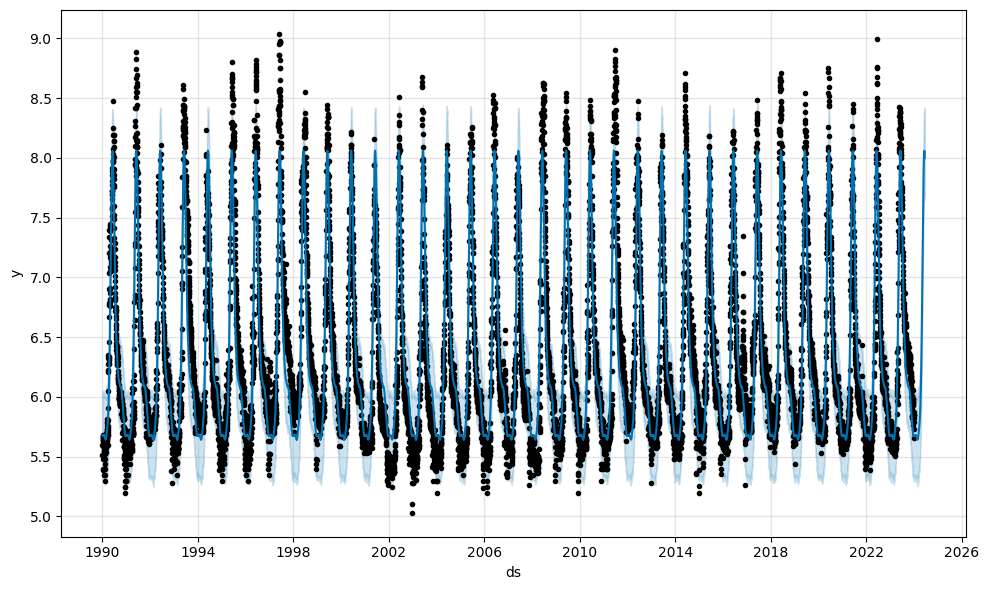

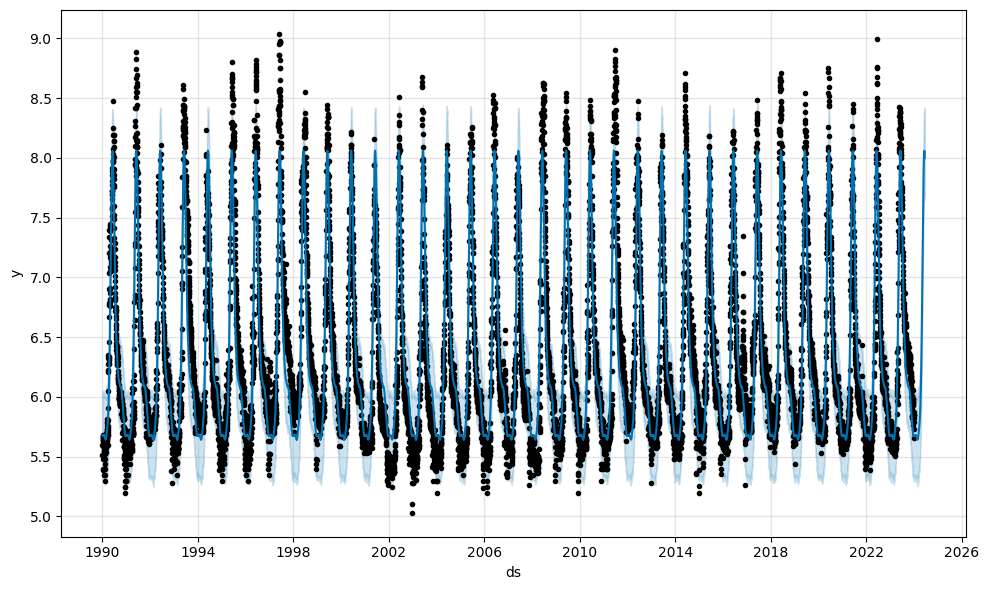

In [7]:
periods_forward = len(test) - 1
future = m.make_future_dataframe(periods=periods_forward)
forecast = m.predict(future)
m.plot(forecast)

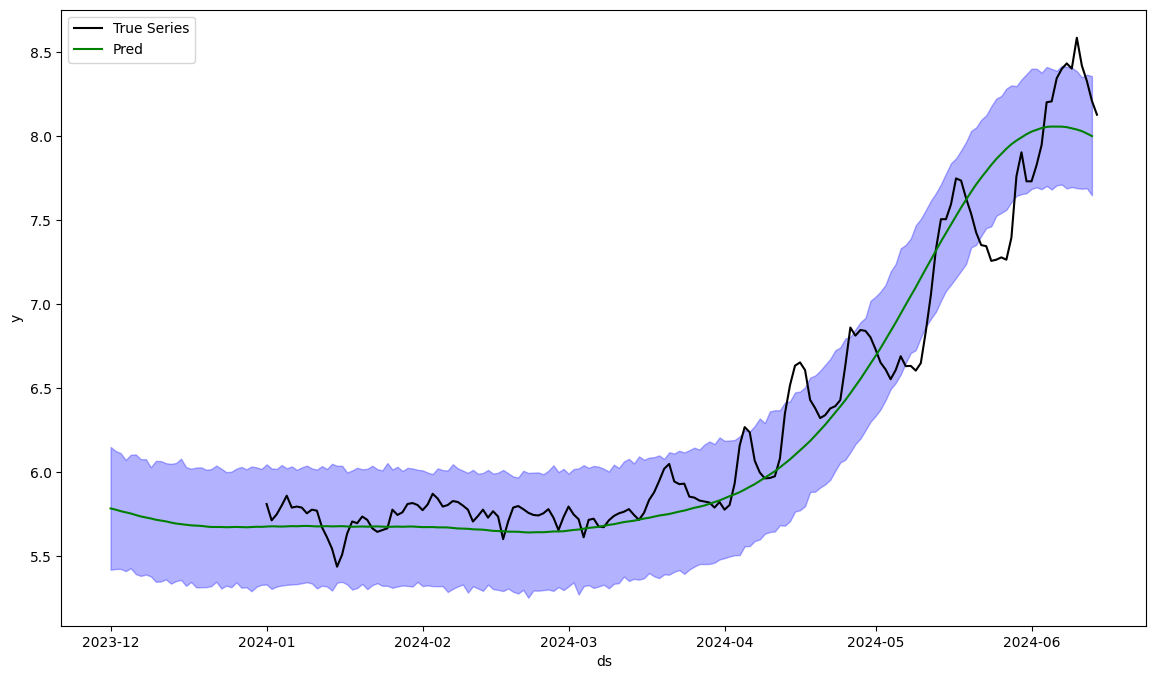

In [8]:
tail = len(test) + 30
plt.figure(figsize=(14, 8))

sns.lineplot(x='ds', y='y', data=test, label='True Series', color='black')

sns.lineplot(x='ds', y='yhat', data=forecast.tail(tail), label='Pred', color='green')
plt.fill_between(forecast['ds'].tail(tail), forecast['yhat_lower'].tail(tail), forecast['yhat_upper'].tail(tail), color='blue', alpha=0.3)

# sns.lineplot(x='time', y='pred2', data=forecast, label='Prediction 2', color='red')
# plt.fill_between(df['time'], df['ci_lower2'], df['ci_upper2'], color='red', alpha=0.3)
plt.show()

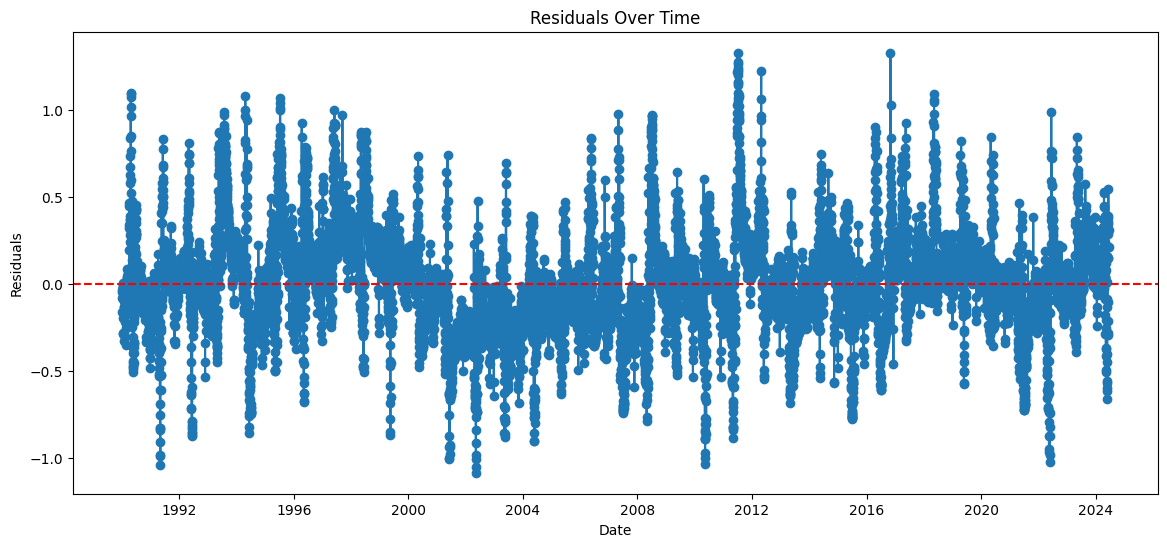

In [9]:
df_merged = df.set_index('ds').join(forecast.set_index('ds'))

# Calculate residuals
df_merged['residuals'] = df_merged['y'] - df_merged['yhat']
plt.figure(figsize=(14, 6))
plt.plot(df_merged.index, df_merged['residuals'], marker='o', linestyle='-')
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.show()

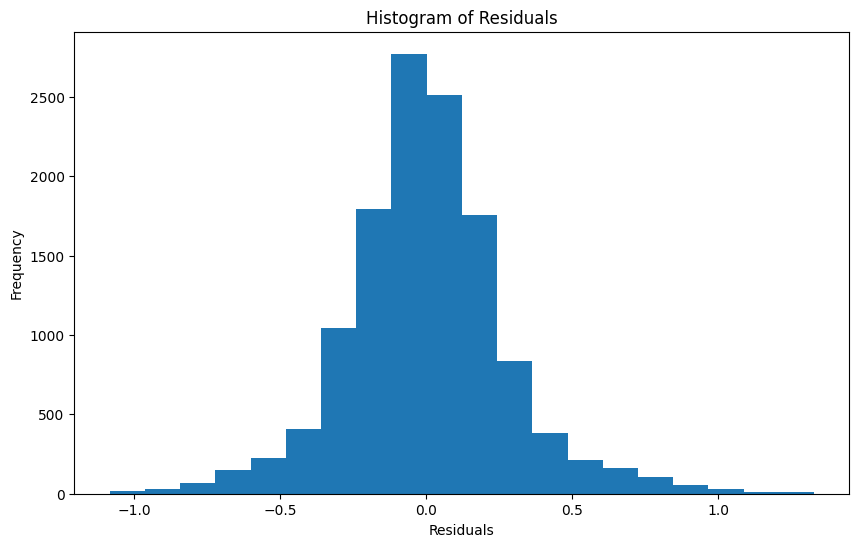

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(df_merged['residuals'], bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

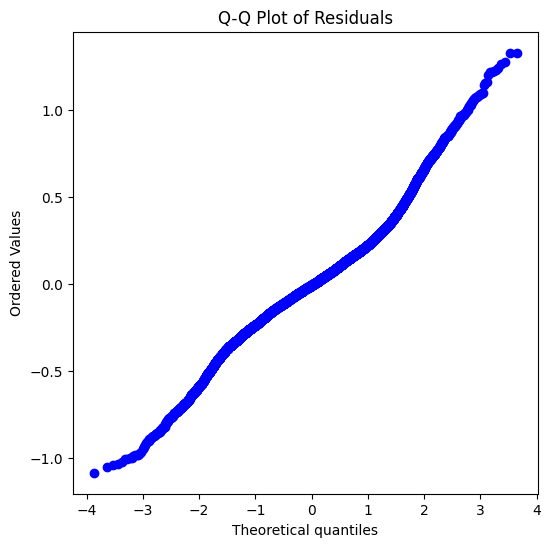

In [11]:
plt.figure(figsize=(6, 6))
stats.probplot(df_merged['residuals'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Now with covariates

In [23]:
mc = Prophet(seasonality_mode="multiplicative", 
            growth='flat')
mc.add_regressor('TAVG_origValue', mode='multiplicative')
mc.add_regressor('TAVG_lag_1', mode='multiplicative')
mc.add_regressor('TAVG_lag_2', mode='multiplicative')
mc.add_regressor('TAVG_lag_3', mode='multiplicative')
mc.add_regressor('WTEQ_average', mode='multiplicative')
mc.add_regressor('WTEQ_origValue', mode='multiplicative')
mc.fit(train)

16:06:56 - cmdstanpy - INFO - Chain [1] start processing
16:06:56 - cmdstanpy - INFO - Chain [1] done processing


/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


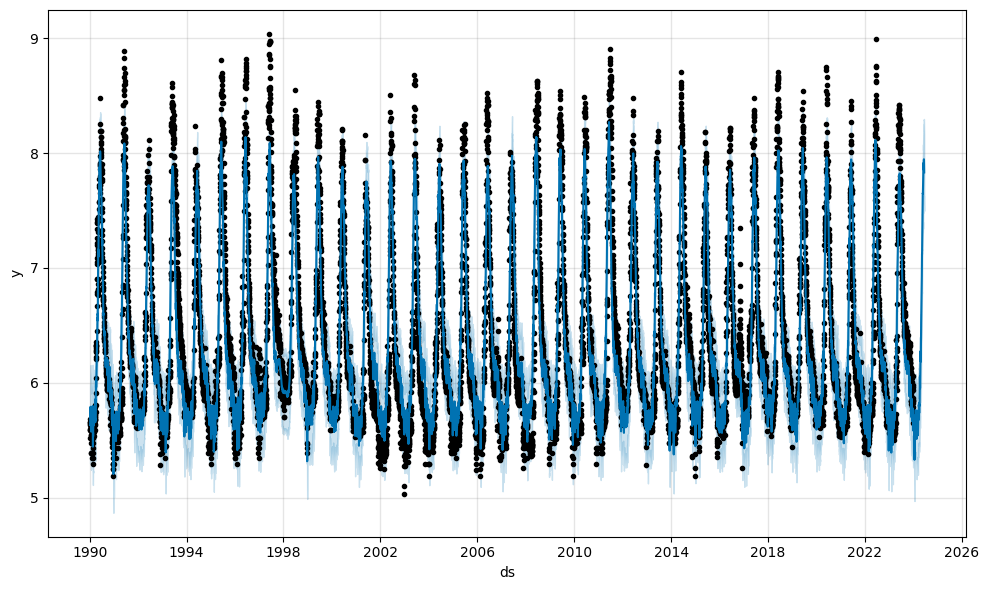

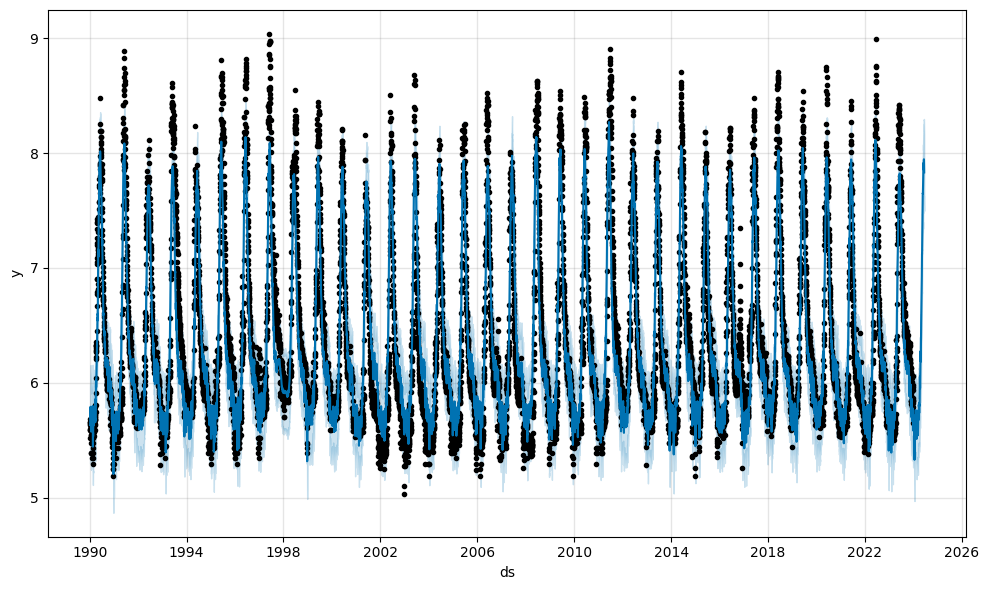

In [24]:
future_c = mc.make_future_dataframe(periods=periods_forward)
future_c['TAVG_origValue'] = df['TAVG_origValue']
future_c['TAVG_lag_1'] = df['TAVG_lag_1']
future_c['TAVG_lag_2'] = df['TAVG_lag_2']
future_c['TAVG_lag_3'] = df['TAVG_lag_3']
future_c['WTEQ_average'] = df['WTEQ_average']
future_c['WTEQ_origValue'] = df['WTEQ_origValue']
future_c.dropna(inplace=True)
forecast_c = mc.predict(future_c)
mc.plot(forecast_c)

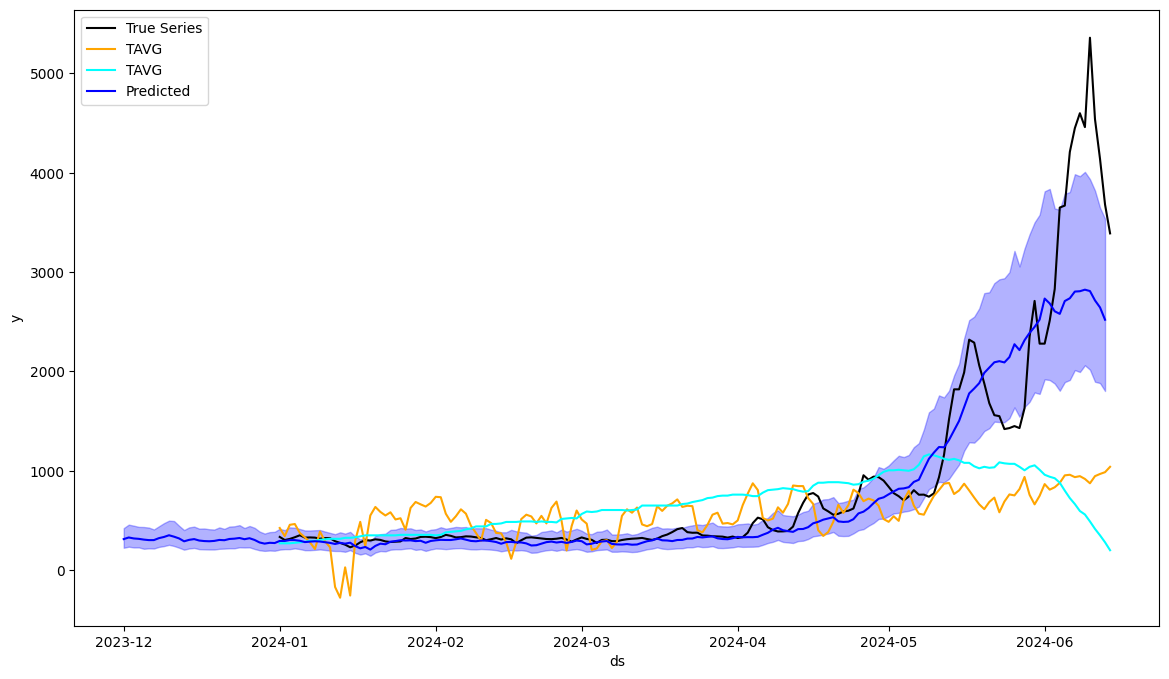

In [31]:
tail = len(test) + 30
plt.figure(figsize=(14, 8))
test_untransformed = test.copy()
test_untransformed['y'] = test['y'].apply(np.exp)
test_untransformed['TAVG_scaled_up'] = test['TAVG_origValue'].apply(lambda x: x*20)
test_untransformed['WTEQ_origValue'] = test['WTEQ_origValue'].apply(lambda x: x*50)

forecast_untransformed = forecast_c.copy()
forecast_untransformed['yhat'] = forecast_c['yhat'].apply(np.exp)
forecast_untransformed['yhat_lower'] = forecast_c['yhat_lower'].apply(np.exp)
forecast_untransformed['yhat_upper'] = forecast_c['yhat_upper'].apply(np.exp)
sns.lineplot(x='ds', y='y', data=test_untransformed, label='True Series', color='black')
sns.lineplot(x='ds', y='TAVG_scaled_up', data=test_untransformed, label='TAVG', color='orange')
sns.lineplot(x='ds', y='WTEQ_origValue', data=test_untransformed, label='TAVG', color='aqua')

sns.lineplot(x='ds', y='yhat', 
             data=forecast_untransformed.tail(tail), 
             label='Predicted',
             color='blue')
plt.fill_between(forecast_untransformed['ds'].tail(tail),
                 forecast_untransformed['yhat_lower'].tail(tail),
                 forecast_untransformed['yhat_upper'].tail(tail),
                 color='blue', alpha=0.3)

# sns.lineplot(x='time', y='pred2', data=forecast, label='Prediction 2', color='red')
# plt.fill_between(df['time'], df['ci_lower2'], df['ci_upper2'], color='red', alpha=0.3)
plt.show()

# Compare metrics between the two models

In [46]:
df_cv = cross_validation(m, initial='1825 days', period='180 days', horizon = '365 days', parallel="processes")
dfc_cv = cross_validation(mc, initial='1825 days', period='180 days', horizon = '365 days', parallel="processes")

16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1] done processing
16:21:43 - cmdstanpy - INFO - Chain [1] start processing
16:21:43 - cmdstanpy - INFO - Chain [1

### No Covariates performance

In [44]:
performance_metrics(df_cv).mean()

horizon     201 days 00:00:00
mse                  0.080746
rmse                 0.283435
mae                  0.209207
mape                 0.032262
mdape                0.024755
smape                0.032104
coverage             0.831737
dtype: object

### With Covariates performance

In [48]:
performance_metrics(dfc_cv).mean()

horizon     201 days 00:00:00
mse                  0.074331
rmse                 0.272128
mae                  0.198839
mape                 0.030673
mdape                0.022804
smape                0.030454
coverage              0.83025
dtype: object

## Plots of models' MAPE over time

/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


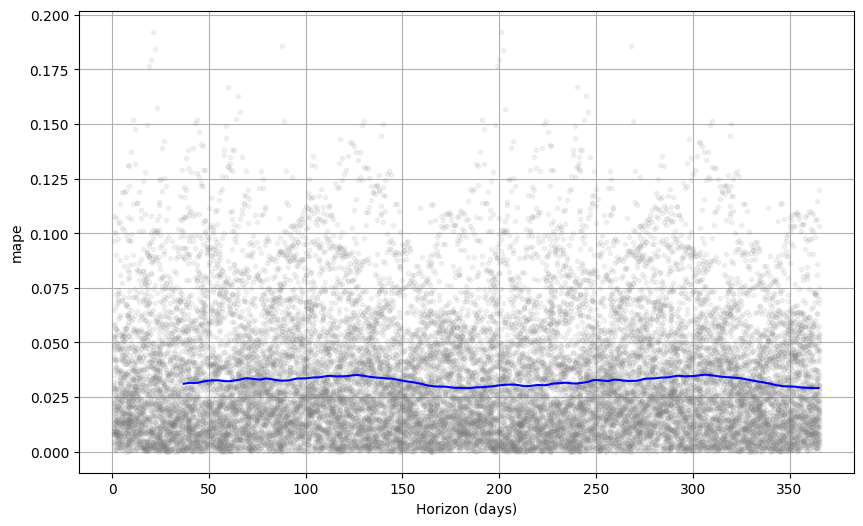

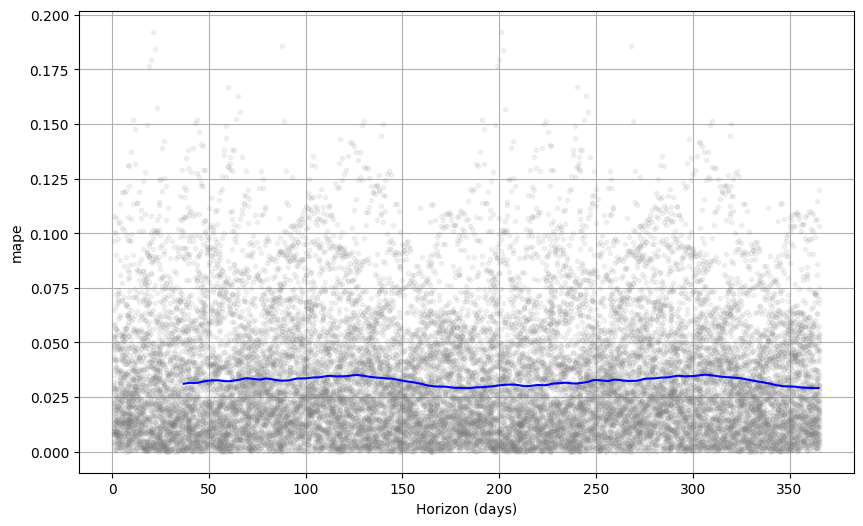

In [45]:
plot_cross_validation_metric(df_cv, metric='mape')

/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/home/krasky/projects/gallaflow/explore/.venv/lib/python3.10/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


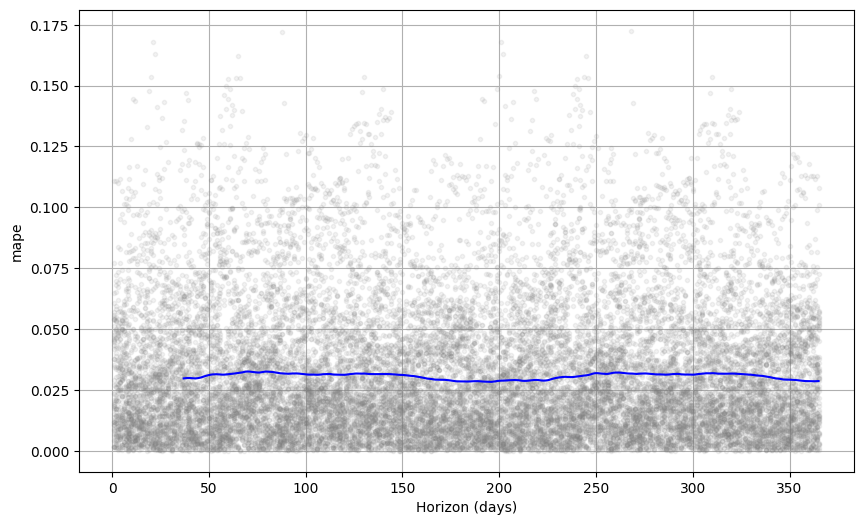

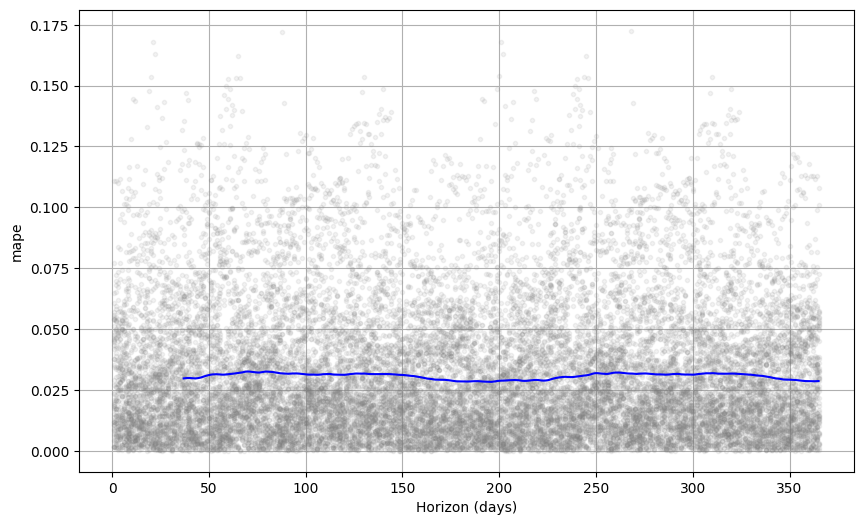

In [49]:
plot_cross_validation_metric(dfc_cv, metric='mape')